In [2]:
import numpy as np
from tqdm import tqdm
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt



In [3]:
with open("training_history.json", "r") as f:
    history = json.load(f)
    
with open("y_probs.json", "r") as f:
    y_probs = json.load(f)
    
with open("y_true.json", "r") as f:
    y_true = json.load(f)

In [4]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.

    Args:
        history: Dictionary containing 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.show()


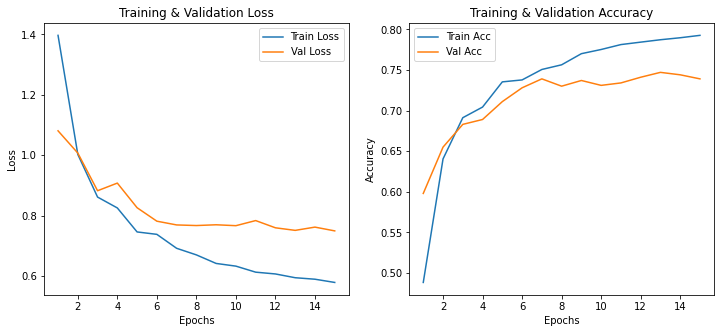

In [5]:
plt.rcdefaults()
plot_training_history(history)

In [6]:
y_true = torch.tensor(y_true, dtype=torch.int64)
y_probs = np.array(y_probs)

In [7]:
# Calculate the accuracy
y_pred = np.argmax(y_probs, axis=1)
accuracy = np.mean(y_true.numpy() == y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7480


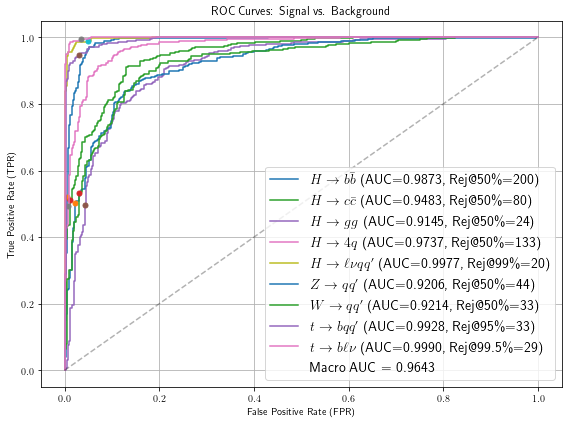

In [11]:
# Ensure LaTeX is correctly rendered in plots
plt.rcParams["text.usetex"] = True

# Define LaTeX-formatted labels
label_list = [
    r"$q/g$ (background)",
    r"$H \to b\bar{b}$",
    r"$H \to c\bar{c}$",
    r"$H \to gg$",
    r"$H \to 4q$",
    r"$H \to \ell\nu qq'$",
    r"$Z \to qq'$",
    r"$W \to qq'$",
    r"$t \to bqq'$",
    r"$t \to b\ell\nu$",
]

background_class_label = r"$q/g$ (background)"

rejection_ratios = []

def plot_roc_curves_vs_background(y_true, y_probs, class_labels, background_class_label, tpr_target=0.5, figsize=(8, 6)):
    """Plots ROC curves for each signal class against the background."""

    background_idx = class_labels.index(background_class_label)
    plt.figure(figsize=figsize)

    for i, class_label in enumerate(class_labels):
        if class_label == background_class_label:
            continue  # Skip background class
        
        if class_label == r"$H \to \ell\nu qq'$":
            # Mask for signal vs. background
            mask = (np.array(y_true) == i) | (np.array(y_true) == background_idx)
            y_true_bin = np.array([1 if y == i else 0 for y in y_true])[mask]
            y_score = y_probs[:, i][mask]

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            auc = roc_auc_score(y_true_bin, y_score)

            # Rejection point
            idx = np.argmin(np.abs(tpr - 0.99))
            fpr_at_target = fpr[idx]
            tpr_at_target = tpr[idx]
            rej = 1 / fpr_at_target if fpr_at_target > 0 else float("inf")
            rejection_ratios.append(rej)

            # Label with LaTeX rendering
            label = rf"{class_label} (AUC={auc:.4f}, Rej@{int(0.99*100)}\%={rej:.0f})"
            plt.plot(fpr, tpr, label=label)
            plt.plot(fpr_at_target, tpr_at_target, "o", markersize=5)
            
        elif class_label == r"$t \to bqq'$":
            # Mask for signal vs. background
            mask = (np.array(y_true) == i) | (np.array(y_true) == background_idx)
            y_true_bin = np.array([1 if y == i else 0 for y in y_true])[mask]
            y_score = y_probs[:, i][mask]

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            auc = roc_auc_score(y_true_bin, y_score)

            # Rejection point
            idx = np.argmin(np.abs(tpr - 0.95))
            fpr_at_target = fpr[idx]
            tpr_at_target = tpr[idx]
            rej = 1 / fpr_at_target if fpr_at_target > 0 else float("inf")
            rejection_ratios.append(rej)

            # Label with LaTeX rendering
            label = rf"{class_label} (AUC={auc:.4f}, Rej@{95}\%={rej:.0f})"
            plt.plot(fpr, tpr, label=label)
            plt.plot(fpr_at_target, tpr_at_target, "o", markersize=5)
            
        elif class_label == r"$t \to b\ell\nu$":
            # Mask for signal vs. background
            mask = (np.array(y_true) == i) | (np.array(y_true) == background_idx)
            y_true_bin = np.array([1 if y == i else 0 for y in y_true])[mask]
            y_score = y_probs[:, i][mask]

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            auc = roc_auc_score(y_true_bin, y_score)

            # Rejection point
            idx = np.argmin(np.abs(tpr - 0.995))
            fpr_at_target = fpr[idx]
            tpr_at_target = tpr[idx]
            rej = 1 / fpr_at_target if fpr_at_target > 0 else float("inf")
            rejection_ratios.append(rej)

            # Label with LaTeX rendering
            label = rf"{class_label} (AUC={auc:.4f}, Rej@{99.5:.1f}\%={rej:.0f})"
            plt.plot(fpr, tpr, label=label)
            plt.plot(fpr_at_target, tpr_at_target, "o", markersize=5)
        else:
            # Mask for signal vs. background
            mask = (np.array(y_true) == i) | (np.array(y_true) == background_idx)
            y_true_bin = np.array([1 if y == i else 0 for y in y_true])[mask]
            y_score = y_probs[:, i][mask]

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            auc = roc_auc_score(y_true_bin, y_score)

            # Rejection point
            idx = np.argmin(np.abs(tpr - tpr_target))
            fpr_at_target = fpr[idx]
            tpr_at_target = tpr[idx]
            rej = 1 / fpr_at_target if fpr_at_target > 0 else float("inf")
            rejection_ratios.append(rej)

            # Label with LaTeX rendering
            label = rf"{class_label} (AUC={auc:.4f}, Rej@{int(tpr_target*100)}\%={rej:.0f})"
            plt.plot(fpr, tpr, label=label)
            plt.plot(fpr_at_target, tpr_at_target, "o", markersize=5)
            
    macro_auc = roc_auc_score(y_true,y_probs, average="macro", multi_class="ovo")
    plt.plot([], [], " ", label=rf"Macro AUC = {macro_auc:.4f}")
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curves: Signal vs. Background")
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("JetClass_ParT_ROC_Curves.png")
    plt.show()
    return rejection_ratios

rejection_ratios = plot_roc_curves_vs_background(y_true, y_probs, label_list, background_class_label)


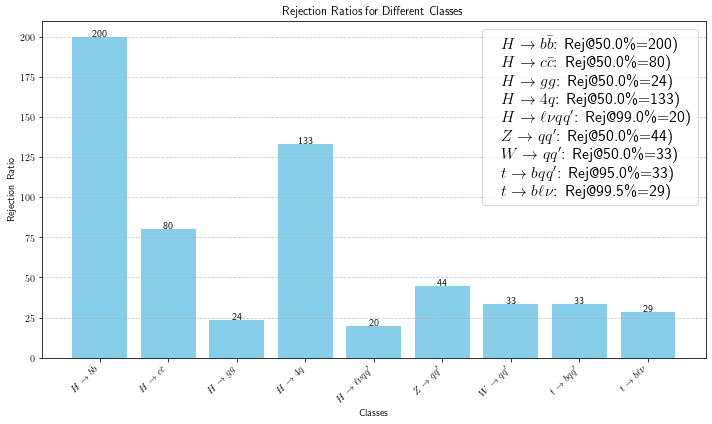

In [ ]:
import matplotlib.pyplot as plt

def plot_rejection_ratios(rejection_ratios):
    """Plots a bar chart for rejection ratios with a legend explicitly listing values and target TPRs."""

    label_list = [
        r"$H \to b\bar{b}$",
        r"$H \to c\bar{c}$",
        r"$H \to gg$",
        r"$H \to 4q$",
        r"$H \to \ell\nu qq'$",
        r"$Z \to qq'$",
        r"$W \to qq'$",
        r"$t \to bqq'$",
        r"$t \to b\ell\nu$",
    ]

    target_tprs = [0.5] * len(label_list)  # Default to 0.5
    target_tprs[label_list.index(r"$H \to \ell\nu qq'$")] = 0.99
    target_tprs[label_list.index(r"$t \to bqq'$")] = 0.95
    target_tprs[label_list.index(r"$t \to b\ell\nu$")] = 0.995

    if len(rejection_ratios) != len(label_list):
        raise ValueError(f"Mismatch: Expected {len(label_list)} rejection ratios, got {len(rejection_ratios)}.")

    plt.figure(figsize=(10, 6))
    bars = plt.bar(label_list, rejection_ratios, color="skyblue")

    # Annotate each bar with its rejection ratio value
    for bar, rej in zip(bars, rejection_ratios):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"{rej:.0f}", ha='center', fontsize=10)

    plt.xlabel("Classes")
    plt.ylabel("Rejection Ratio")
    plt.title("Rejection Ratios for Different Classes")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    legend_text = "\n".join(
        [f"{label}: Rej@{tpr*100:.1f}\%={rej:.0f})" for label, tpr, rej in zip(label_list, target_tprs, rejection_ratios)]
    )

    plt.legend([plt.Line2D([0], [0], color='white')], [legend_text], loc="upper right", fontsize=16, frameon=True, handlelength=0)

    plt.tight_layout()
    plt.savefig("JetClass_ParT_rejectionRatios.png")
    plt.show()

plot_rejection_ratios(rejection_ratios)
